In [40]:
import pandas as pd 
import matplotlib.pyplot as plt

In [41]:
patient_users = ["juan", "ana", "jesus", "susana", "joan", "anton", "gloria", "ricard", "ismael", "carles", "alfredo", "rosacano", "rafael", "jose", "godo", "mcarmen", "juanfran", "Carmen", "Hassan", "Marisa",
    "PP01", "PP02", "PP03", "PP04", "PP05", "PP06", "PP07",
    "user_it01", "user_it01a", "user_it02", "user_it02a", "user_it03", "user_it03a", "user_it04", "user_it04a", "user_it05", "user_it05a", "user_it06", "user_it06a", "user_it07", "user_it07a", "user_it08", "user_it08a", "user_it09", "user_it09a", 'user_it10', "user_it10a"

]

In [42]:
patient_df = pd.read_csv("data/patient.csv")

In [43]:
patient_df = patient_df[patient_df["HOSPITAL_ID"].isin([11, 40, 41])]

In [44]:
patient_ids = [patient_df.iloc[i]["PATIENT_ID"] for i in range(len(patient_df)) if patient_df.iloc[i]["PATIENT_USER"] in patient_users]


In [45]:
id_to_hospital_name = {
    11: "Vall d'Hebron",
    40: "INRCA", 
    41: "Sint Maartenskliniek"
    
}

In [46]:
patient_to_hospital = {i[1]["PATIENT_ID"]:id_to_hospital_name[i[1]["HOSPITAL_ID"]] for i in patient_df.iterrows()}

In [47]:
prescriptions = pd.read_csv("data/prescription_app.csv")


In [48]:
sessions = pd.read_csv("data/session_app.csv")


In [49]:
recordings = pd.read_csv("data/recording_app.csv")
recordings = recordings[recordings["RECORDING_KEY"] == "sessionDuration(seconds)"]


In [50]:
patient_df = patient_df[patient_df["PATIENT_ID"].isin(patient_ids)]


In [51]:
prescriptions = prescriptions[prescriptions["PATIENT_ID"].isin(patient_ids)]


In [52]:
prescriptions = prescriptions[prescriptions["ENDING_DATE"] != "0000-00-00 00:00:00"]

In [53]:
sessions = sessions[sessions["PRESCRIPTION_ID"].isin(prescriptions["PRESCRIPTION_ID"])]


In [54]:
session_to_date = {i[1]["SESSION_ID"]:i[1]["STARTING_DATE"] for i in sessions.iterrows()}

In [55]:
prescription_to_session = {i[1]["PRESCRIPTION_ID"]:i[1]["SESSION_ID"] for i in sessions.iterrows()}


In [56]:
prescription_to_patient_id = {i[1]["PRESCRIPTION_ID"]:i[1]["PATIENT_ID"] for i in prescriptions.iterrows()}


In [57]:
sessions["PATIENT_ID"] = [prescription_to_patient_id[i] for i in sessions["PRESCRIPTION_ID"]]


In [58]:
count = 0
for i in prescriptions["PRESCRIPTION_ID"]:
    if i not in prescription_to_session:
        count+=1
        prescription_to_session[i] = 0


In [59]:
# Convert the date columns from strings to datetime objects
prescriptions['STARTING_DATE'] = pd.to_datetime(prescriptions['STARTING_DATE'])
prescriptions['ENDING_DATE'] = pd.to_datetime(prescriptions['ENDING_DATE'])

# Calculate the difference in weeks and convert to integer (floor division)
prescriptions['WEEKS'] = ((prescriptions['ENDING_DATE'] - prescriptions['STARTING_DATE']) / pd.Timedelta(weeks=1)).astype(int)



In [60]:
recordings = recordings[recordings["SESSION_ID"].isin(sessions["SESSION_ID"])]
recordings["SESSION_DATE"] = [session_to_date[session] for session in recordings.SESSION_ID]


In [61]:
# Convert the date columns to datetime
prescriptions['STARTING_DATE'] = pd.to_datetime(prescriptions['STARTING_DATE'])
prescriptions['ENDING_DATE'] = pd.to_datetime(prescriptions['ENDING_DATE'])
recordings['SESSION_DATE'] = pd.to_datetime(recordings['SESSION_DATE'])

patient_start = {patient_id:min(recordings[recordings["PATIENT_ID"] == patient_id].SESSION_DATE) for patient_id in recordings["PATIENT_ID"].unique()}

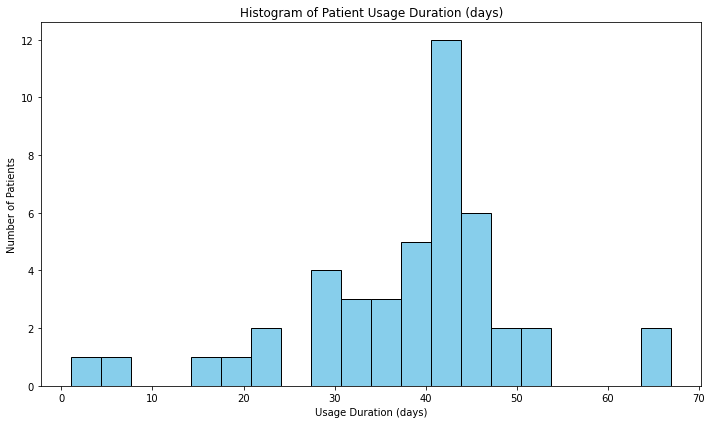

In [62]:
usage_stats = recordings.groupby('PATIENT_ID')['SESSION_DATE'].agg(['min', 'max']).reset_index()

# Calculate usage duration as the difference between max and min session dates
usage_stats['usage_duration'] = usage_stats['max'] - usage_stats['min']


usage_stats['usage_days'] = usage_stats['usage_duration'].dt.total_seconds() / (3600 * 24)

# Create a histogram of usage days
plt.figure(figsize=(10, 6))
plt.hist(usage_stats['usage_days'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Usage Duration (days)")
plt.ylabel("Number of Patients")
plt.title("Histogram of Patient Usage Duration (days)")
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd



# Dictionary to hold the results
adherence_dict = {}

for _, prescription in prescriptions.iterrows():
    # Extract prescription details
    patient_id = prescription["PATIENT_ID"]
    protocol = prescription["PROTOCOL_ID"]
    start_date = prescription["STARTING_DATE"]
    end_date = prescription["ENDING_DATE"]
    # WEEKDAY is a string like "MONDAY"
    prescribed_weekday = prescription["WEEKDAY"].upper()  # ensure uppercase
    prescribed_duration = prescription["SESSION_DURATION"]

    # Cap the prescription window to 7 weeks from the start date
    if patient_id in patient_start:
        cap_date = patient_start[patient_id] + pd.Timedelta(weeks=7)
    else:
        cap_date = start_date
    
    effective_end_date = min(end_date, cap_date)

    # Generate all dates from start_date to effective_end_date
    all_dates = pd.date_range(start=start_date, end=effective_end_date)
    # Filter for dates that match the prescribed weekday.
    prescribed_dates = [
        d for d in all_dates if d.strftime("%A").upper() == prescribed_weekday
    ]

    # Dictionary to store adherence for each prescribed date
    adherence_per_date = {}
    adherence_per_day = {}

    for date in prescribed_dates:
        # For each date, filter sessions matching patient, protocol, and date.
        # Normalize dates to ignore the time component.
        session_rows = recordings[
            (recordings["PATIENT_ID"] == patient_id) &
            (recordings["PROTOCOL_ID"] == protocol) &
            (recordings["SESSION_DATE"].dt.normalize() == date.normalize())
        ]
        
        if not session_rows.empty:
            # Sum all session durations for that date (handle multiple sessions)
            total_actual_duration = session_rows["RECORDING_VALUE"].sum()
            adherence = min(1, total_actual_duration/prescribed_duration)
            adherence_day = 1
        else:
            adherence = 0
            adherence_day = 0

        # Store the adherence for this date using just the date portion
        adherence_per_date[date.date()] = adherence
        adherence_per_day[date.date()] = adherence_day

    # Initialize the patient key if it doesn't exist yet
    if patient_id not in adherence_dict:
        adherence_dict[patient_id] = {}
    
    # Store the protocol's adherence info.
    # (If a patient has multiple prescriptions for the same protocol,
    #  you might need additional logic to combine them.)
    adherence_dict[patient_id][protocol] = {
        "adherence_per_session": adherence_per_date,
        "adherence_per_day":adherence_per_day
    }



In [64]:
records = []
for patient, protocols in adherence_dict.items():
    for protocol, details in protocols.items():
        hospital = patient_to_hospital[patient]
        for session_date, adherence in details["adherence_per_session"].items():
            records.append({
                "patient": patient,
                "protocol": protocol,
                "hospital": hospital,
                "session_date": session_date,  # this is a date object
                "adherence": adherence,
               
            })
day_col = []
for patient, protocols in adherence_dict.items():
    for protocol, details in protocols.items():
        hospital = patient_to_hospital[patient]
        for session_date, adherence in details["adherence_per_day"].items():
            day_col.append(adherence)


df_sessions = pd.DataFrame(records)
df_sessions["adherence_day"] = day_col

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interactive_output, Tab, FloatSlider
from IPython.display import display

df_sessions['session_date'] = pd.to_datetime(df_sessions['session_date'])

# -----------------------------------------------------------------------------
# Function for session-based adherence plots.
def update_session_plots(threshold):
    # Filter patients based on the usage_days threshold.
    valid_patients = usage_stats.loc[usage_stats['usage_days'] >= threshold, 'PATIENT_ID']
    filtered_sessions = df_sessions[df_sessions['patient'].isin(valid_patients)]
    
    # Calculate average session-level adherence per patient.
    patient_adherence = (
        filtered_sessions.groupby('patient')['adherence']
        .mean()
        .reset_index()
    )
    
    # Create two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Histogram for patient-level adherence.
    sns.histplot(patient_adherence['adherence'], bins=10, kde=False, 
                 color='skyblue', edgecolor='black', ax=axes[0])
    axes[0].set_title("Distribution of Average Session-based Adherence per Patient")
    axes[0].set_xlabel("Average Adherence")
    axes[0].set_ylabel("Number of Patients")
    num_patients = len(patient_adherence)
    axes[0].text(0.6, 0.95, f"Total Patients: {num_patients}", 
                 transform=axes[0].transAxes, ha="right", va="top",
                 bbox=dict(facecolor="white", alpha=0.5))
    
    # For hospital-level session-based adherence, we compute the mean per hospital.
    hosp_session = filtered_sessions.groupby('hospital')['adherence'].mean().reset_index()
    # Bar plot for hospital-level adherence.
    sns.barplot(data=hosp_session, x='hospital', y='adherence', ax=axes[1])
    axes[1].set_title("Session-based Adherence per Hospital")
    axes[1].set_xlabel("Hospital")
    axes[1].set_ylabel("Average Adherence")
    
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# Function for day-based adherence plots (with prescription check).
def update_day_plots(threshold):
        # Filter patients based on the usage_days threshold.
    valid_patients = usage_stats.loc[usage_stats['usage_days'] >= threshold, 'PATIENT_ID']
    filtered_sessions = df_sessions[df_sessions['patient'].isin(valid_patients)]
    
    # Calculate average session-level adherence per patient.
    patient_adherence = (
        filtered_sessions.groupby('patient')['adherence_day']
        .mean()
        .reset_index()
    )
    
    # Create two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Histogram for patient-level adherence.
    sns.histplot(patient_adherence['adherence_day'], bins=10, kde=False, 
                 color='skyblue', edgecolor='black', ax=axes[0])
    axes[0].set_title("Distribution of Average Session-based Adherence per Patient")
    axes[0].set_xlabel("Average Adherence")
    axes[0].set_ylabel("Number of Patients")
    num_patients = len(patient_adherence)
    axes[0].text(0.6, 0.95, f"Total Patients: {num_patients}", 
                 transform=axes[0].transAxes, ha="right", va="top",
                 bbox=dict(facecolor="white", alpha=0.5))
    
    # For hospital-level session-based adherence, we compute the mean per hospital.
    hosp_session = filtered_sessions.groupby('hospital')['adherence_day'].mean().reset_index()
    # Bar plot for hospital-level adherence.
    sns.barplot(data=hosp_session, x='hospital', y='adherence_day', ax=axes[1])
    axes[1].set_title("Session-based Adherence per Hospital")
    axes[1].set_xlabel("Hospital")
    axes[1].set_ylabel("Average Adherence")
    
    plt.tight_layout()
    plt.show()

    
# -----------------------------------------------------------------------------
# Create a common interactive slider for the usage threshold (in days).
max_usage = usage_stats['usage_days'].max() if not usage_stats.empty else 30
threshold_slider = FloatSlider(min=0, max=45, step=0.1, value=0, description="Min Usage (days)")

# Create interactive outputs for each adherence definition.
session_out = interactive_output(update_session_plots, {'threshold': threshold_slider})
day_out = interactive_output(update_day_plots, {'threshold': threshold_slider})

# Place the two outputs in a Tab widget.
tab = Tab(children=[session_out, day_out])
tab.set_title(0, "Session-based Adherence")
tab.set_title(1, "Day-based Adherence")

# Display the slider and the tabs.
display(threshold_slider, tab)


FloatSlider(value=0.0, description='Min Usage (days)', max=45.0)

In [1]:
import pandas as pd 
sessions = pd.read_csv("data/session_app.csv")
sessions.head()

,SESSION_ID,PRESCRIPTION_ID,STARTING_DATE,ENDING_DATE,STATUS,SESSION_LOG_PARSED
0,1,145,2022-05-20 13:03:57,2022-05-20 13:04:05,ABORTED,0
1,2,89,2022-05-20 13:04:09,2022-05-20 13:04:31,ABORTED,0
2,3,89,2022-05-20 13:04:34,2022-05-20 13:04:47,ABORTED,0
3,4,89,2022-05-20 13:04:51,2022-05-20 13:05:18,ABORTED,0
4,5,89,2022-05-20 13:05:21,2022-05-20 13:05:26,ABORTED,0


In [3]:
recordings = pd.read_csv("data/recording_app.csv")
recordings.head()

,RECORDING_ID,SESSION_ID,PATIENT_ID,PROTOCOL_ID,RECORDING_KEY,RECORDING_VALUE
0,1,1,91,210,score,0
1,2,1,91,210,totalErrors,0
2,3,1,91,210,totalSuccess,0
3,4,1,91,210,sessionDuration(seconds),0
4,5,2,91,201,score,3


In [10]:
df.PATIENT_ID.unique()

array([ 204,  775,  787,  788,  946,  947,  953,  955,  957, 1123, 1169,
       1170, 1171, 1172, 1173, 1222, 1551, 1553, 1555, 1556, 1861, 1983,
       2110, 2195, 2843, 2913, 2925, 2926, 2937, 2954, 2955, 2956, 2957,
       2958, 2959, 2960, 2961, 2962, 2963, 3081, 3210, 3213, 3222, 3229,
       3231, 3318, 3432], dtype=int64)

In [6]:
df = pd.read_csv("data/rgs_app_nest.csv")
df.columns

Index(['PATIENT_ID', 'HOSPITAL_ID', 'PARETIC_SIDE', 'UPPER_EXTREMITY_TO_TRAIN',
       'HAND_RAISING_CAPACITY', 'COGNITIVE_FUNCTION_LEVEL',
       'HAS_HEMINEGLIGENCE', 'GENDER', 'SKIN_COLOR', 'AGE', 'VIDEOGAME_EXP',
       'COMPUTER_EXP', 'COMMENTS', 'PTN_HEIGHT_CM', 'ARM_SIZE_CM',
       'ANSWER_DATE', 'EMOTIONAL_ANSWER_1', 'EMOTIONAL_ANSWER_2',
       'EMOTIONAL_ANSWER_3', 'PRESCRIPTION_ID', 'SESSION_ID', 'PROTOCOL_ID',
       'SESSION_DATE', 'STARTING_HOUR', 'STARTING_TIME_CATEGORY', 'STATUS',
       'PROTOCOL_TYPE', 'AR_MODE', 'WEEKDAY', 'REAL_SESSION_DURATION',
       'PRESCRIBED_SESSION_DURATION', 'SESSION_DURATION', 'ADHERENCE',
       'TOTAL_SUCCESS', 'TOTAL_ERRORS', 'SCORE'],
      dtype='object')

In [89]:
df_sessions.head()

,patient,protocol,hospital,session_date,adherence,adherence_day
0,946,223,Vall d'Hebron,2023-12-10,1.0,1
1,946,223,Vall d'Hebron,2023-12-17,1.0,1
2,946,223,Vall d'Hebron,2023-12-24,1.0,1
3,946,223,Vall d'Hebron,2023-12-31,1.0,1
4,946,223,Vall d'Hebron,2024-01-07,1.0,1


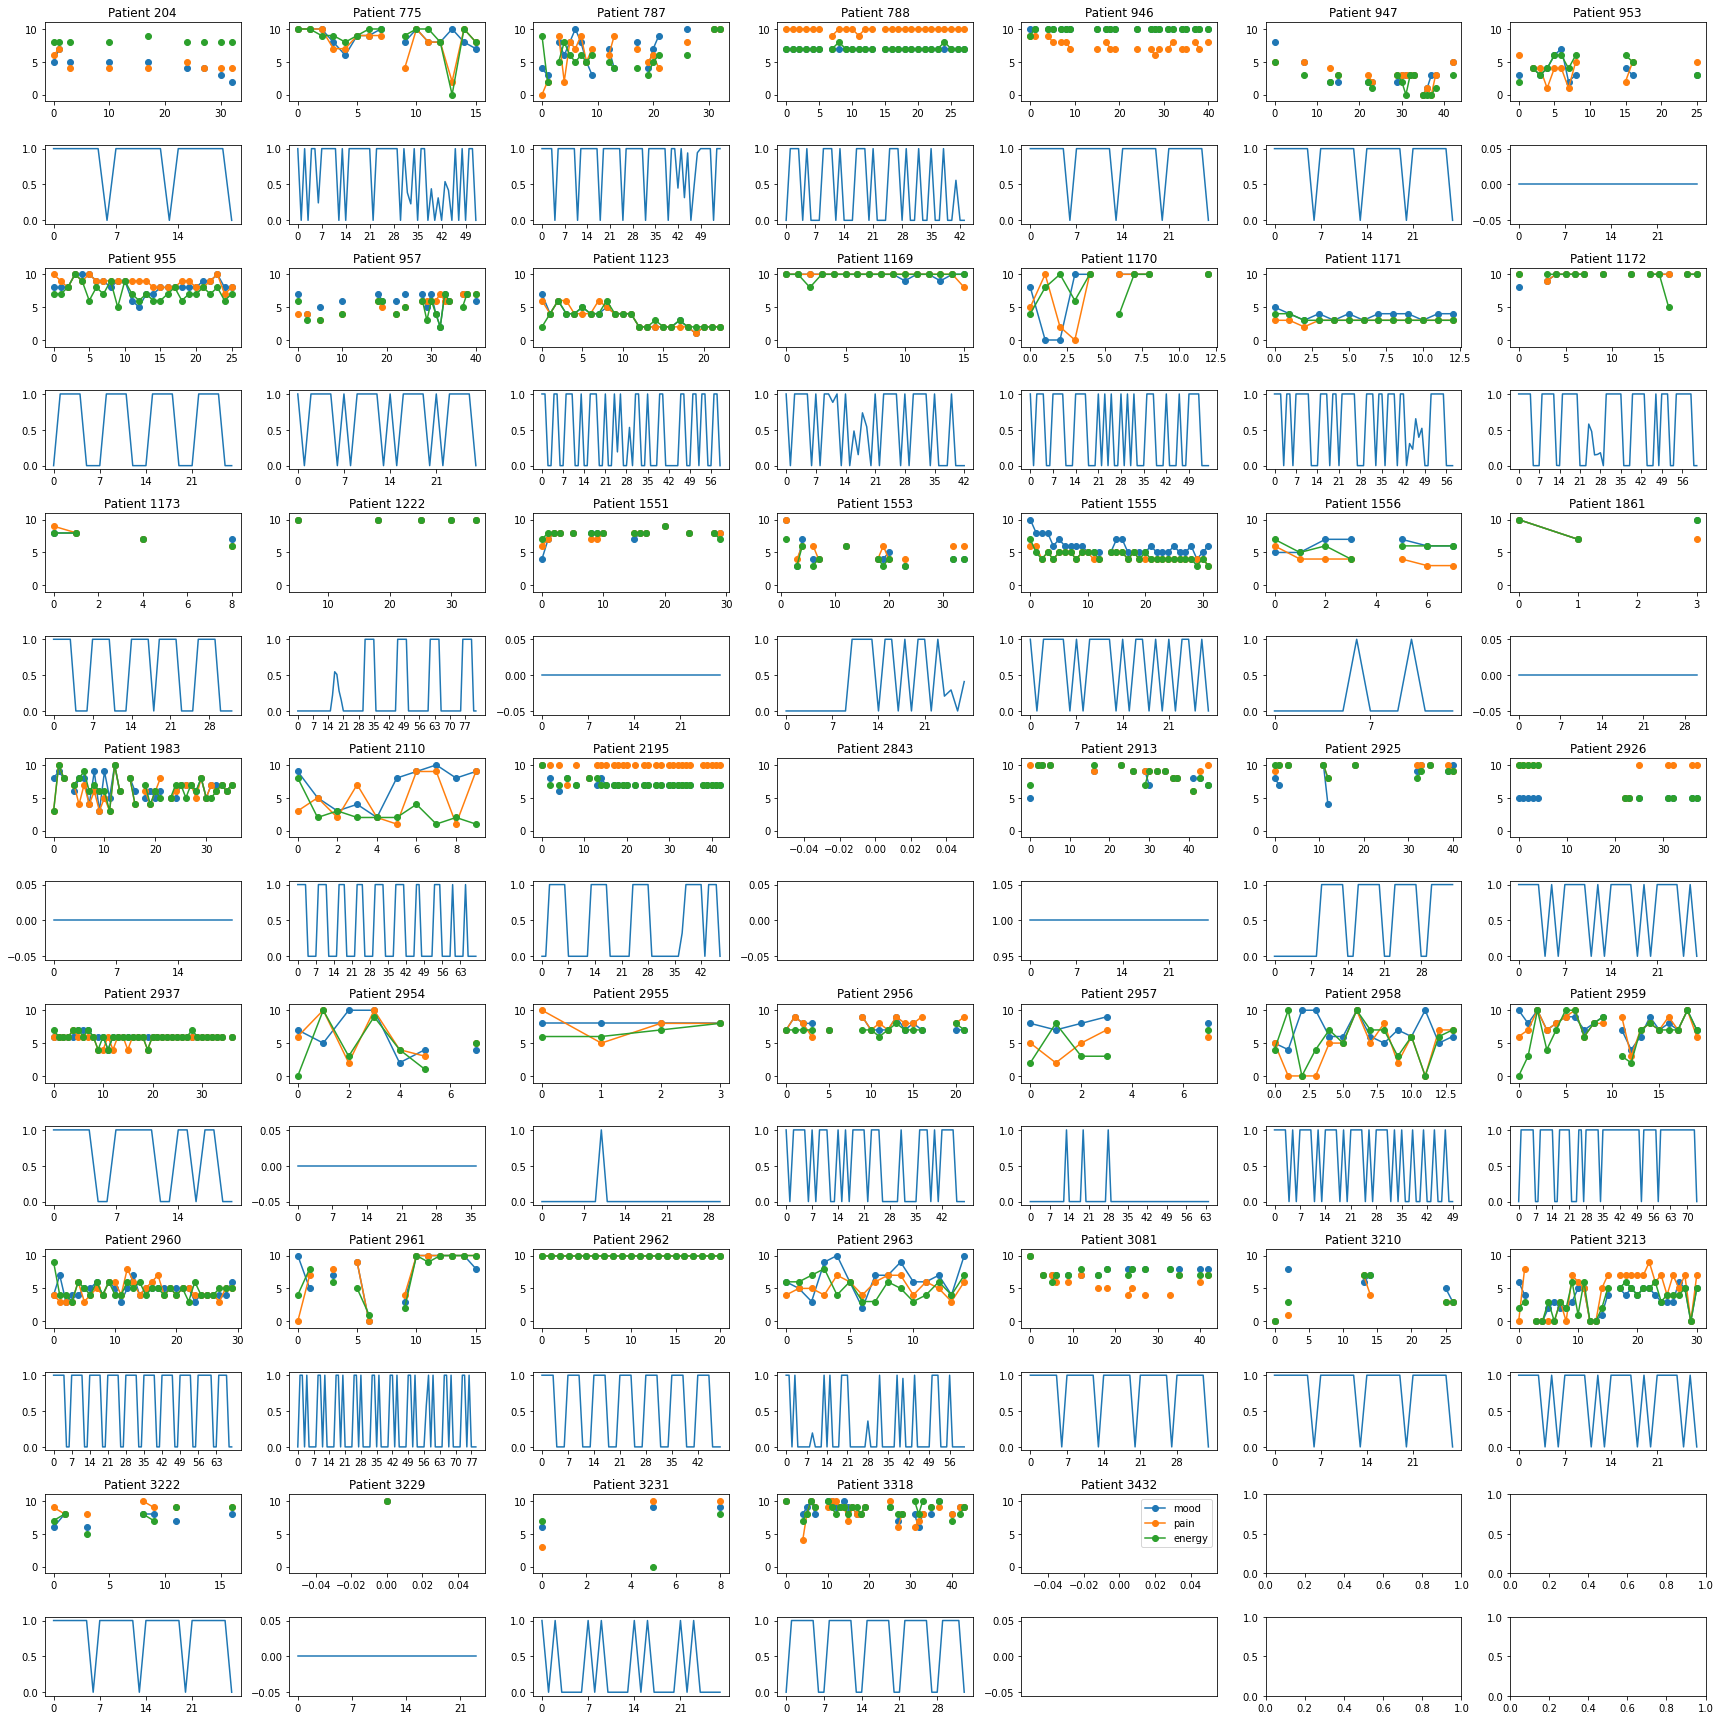

In [92]:
import matplotlib.pyplot as plt

def plot_sliders(ax, patient_id, legend = False):
    df_patient = df[df["PATIENT_ID"] == patient_id]
    df_patient = df_patient[["EMOTIONAL_ANSWER_1", "EMOTIONAL_ANSWER_2", "EMOTIONAL_ANSWER_3", "SESSION_DATE"]]
    df_patient = df_patient.drop_duplicates("SESSION_DATE").reset_index()

    mood = df_patient["EMOTIONAL_ANSWER_1"]
    pain = df_patient["EMOTIONAL_ANSWER_2"]
    energy = df_patient["EMOTIONAL_ANSWER_3"]
    
    ax.plot(mood, label="mood", marker="o")
    ax.plot(pain, label="pain", marker="o")
    ax.plot(energy, label="energy", marker="o")
    
    ax.set_ylim((-1, 11))
    ax.set_title(f"Patient {patient_id}")
    if legend:
        ax.legend()

def plot_adherence(ax, patient_id):
    df_patient = df_sessions[df_sessions["patient"] == patient_id].reset_index()
    ax.plot(df_patient["adherence"])
    ax.set_xticks(range(0, len(df_patient), 7))
    

# Define grid size based on number of patients
num_patients = len(df.PATIENT_ID.unique())
grid_size = int(num_patients ** 0.5) + 1

fig, axes = plt.subplots(grid_size*2, grid_size, figsize=(24, 24))
axes = axes.flatten()

for i, patient_id in enumerate(df.PATIENT_ID.unique()):
    legend=False
    if i == 46:
        legend=True
    
    plot_sliders(axes[(i//7)*(grid_size) + i], patient_id, legend=legend)
    plot_adherence(axes[(i//7)*grid_size + grid_size + i], patient_id)



plt.tight_layout()
plt.show()


In [39]:
df_nan[df_nan["SESSION_ID"] == 44233.0][["PATIENT_ID", "SESSION_DATE"]]

,PATIENT_ID,SESSION_DATE
21,204,2024-09-12
